# Doodles and notes - nothing important

In [ ]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import network_diffusion as nd
import networkx as nx
import pandas as pd
import itertools
from misc.utils import extract_basic_stats

%load_ext autoreload
%autoreload 2

## K++ Shell

In [101]:
from network_diffusion.mln import functions 
from network_diffusion.mln import kppshell
from misc.net_loader import get_aucs_network, get_ckm_physicians_network
nnet = functions.get_toy_network_cim()
nnet = kppshell.get_toy_network_kppshell()
# nnet = get_ckm_physicians_network()

l = nnet["l1"]
# nnet.layers
# l = nnet["advice"]

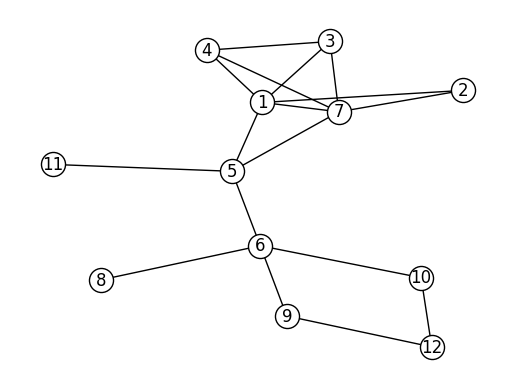

In [102]:
fig, axs = plt.subplots(nrows=1, ncols=1)

layout = nx.drawing.kamada_kawai_layout(l)
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
    "with_labels": True,
}

nx.draw(l, ax=axs, pos=layout, **options)

In [107]:
comms = list(nx.community.label_propagation_communities(l))
print(comms)
print([len(c) for c in comms])

quotas = kppshell.compute_seed_quotas(l, comms, 10)
print(quotas)

[{1, 2, 3, 4, 5, 7, 11}, {6, 8, 9, 10, 12}]
[7, 5]
[6, 4]


In [108]:
shells = kppshell.kppshell_decomposition(l)
shells

# one tuple below has a typo
# 𝐶1 = {(𝐵1, 11, 0), (𝐵2, 5, 1)(𝐵2, 2, 0)(𝐵3, 1, 2), (𝐵3, 7, 2), (𝐵3, 3, 0), (𝐵3, 4, 0)}
# 𝐶2 = {(𝐵1, 8, 0), (𝐵2, 6, 2), (𝐵2, 9, 0), (𝐵2, 10, 0), (𝐵2, 12, 0)}


[[{'node_id': 11, 'shell': 1, 'reward_points': 0},
  {'node_id': 2, 'shell': 2, 'reward_points': 0},
  {'node_id': 5, 'shell': 2, 'reward_points': 1},
  {'node_id': 1, 'shell': 3, 'reward_points': 2},
  {'node_id': 3, 'shell': 3, 'reward_points': 0},
  {'node_id': 4, 'shell': 3, 'reward_points': 0},
  {'node_id': 7, 'shell': 3, 'reward_points': 2}],
 [{'node_id': 8, 'shell': 1, 'reward_points': 0},
  {'node_id': 6, 'shell': 2, 'reward_points': 1},
  {'node_id': 9, 'shell': 2, 'reward_points': 0},
  {'node_id': 10, 'shell': 2, 'reward_points': 0},
  {'node_id': 12, 'shell': 2, 'reward_points': 0}]]

In [109]:
kppshell.kppshell_seed_selection(l, 4), kppshell.kppshell_seed_ranking(l)

({1, 3, 6, 7}, [1, 6, 7, 3, 9, 4, 5, 10, 2, 12, 11, 8])

In [110]:
from network_diffusion.seeding import KPPShellSeedSelector

print(nw_ranking := KPPShellSeedSelector().nodewise(nnet))
KPPShellSeedSelector().actorwise(nnet)

{'l1': [1, 6, 7, 3, 9, 4, 5, 10, 2, 12, 11, 8]}


[MLNetworkActor: 1 at 140543092110528,
 MLNetworkActor: 6 at 140543092108800,
 MLNetworkActor: 7 at 140543092110480,
 MLNetworkActor: 3 at 140543092110384,
 MLNetworkActor: 9 at 140543092103952,
 MLNetworkActor: 4 at 140543092109952,
 MLNetworkActor: 5 at 140543092105296,
 MLNetworkActor: 10 at 140543092108320,
 MLNetworkActor: 2 at 140543092106304,
 MLNetworkActor: 12 at 140543092104720,
 MLNetworkActor: 11 at 140543092111488,
 MLNetworkActor: 8 at 140543092112976]

In [111]:
print({l_name: len(l_ranking) for l_name, l_ranking in nw_ranking.items()})
print({l_name: len(l_graph) for l_name, l_graph in nnet.layers.items()})

{'l1': 12}
{'l1': 12}


## CIM

In [ ]:
from network_diffusion.seeding import cim
from network_diffusion.mln.functions import get_toy_network_cim
nnet = get_toy_network_cim()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3)

layout = nx.drawing.kamada_kawai_layout(nnet["l1"])
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
    "with_labels": True,
}

for idx, (l_name, l_graph) in enumerate(nnet.layers.items()):
    nx.draw(l_graph, ax=axs[idx], pos=layout, **options)

In [ ]:
K = 3
print(f"Layer: l1, ranking: {cim.clique_influence_maximization(nnet['l1'], K, False)}")
print(f"Layer: l2, ranking: {cim.clique_influence_maximization(nnet['l2'], K, False)}")
print(f"Layer: l3, ranking: {cim.clique_influence_maximization(nnet['l3'], K, False)}")

In [ ]:
cim.CIMSeedSelector().actorwise(net=nnet)

## Example rankings for toy network

In [ ]:
rankings = {}

all_selectors = {
    "deg-c": nd.seeding.DegreeCentralitySelector(),
    "k-sh": nd.seeding.KShellSeedSelector(),
    "k-sh-m": nd.seeding.KShellMLNSeedSelector(),
    "nghb-1s": nd.seeding.NeighbourhoodSizeSelector(1),
    "nghb-2s": nd.seeding.NeighbourhoodSizeSelector(2),
    "p-rnk": nd.seeding.PageRankSeedSelector(),
    "p-rnk-m": nd.seeding.PageRankMLNSeedSelector(),
    "v-rnk": nd.seeding.VoteRankSeedSelector(),
    "v-rnk-m": nd.seeding.VoteRankMLNSeedSelector(),
}

for s_name, ss in all_selectors.items():
    _ranking = ss.actorwise(net)
    ranking = {actor.actor_id: place for place, actor in enumerate(_ranking, 1)}

    if rankings.get(s_name) is None:
        rankings[s_name] = {}
    rankings[s_name] = ranking

print(rankings)
ranking_full = pd.DataFrame(rankings)
ranking_full.to_csv("data/findings/toy_network_rank.csv")

# blablabla - it's invalid code
# degree centrality
# _ranking = nd.seeding.DegreeCentralitySelector().actorwise(net)
# ranking = {actor.actor_id: place for place, actor in enumerate(_ranking, 1)}
# score = {k.actor_id:v for k, v in degree(net).items()}

# k-shell, (amend output of node_to_actor_ranking)
# _ranking, _score = nd.seeding.KShellSeedSelector().actorwise(net) 
# ranking = {actor.actor_id: place for place, actor in enumerate(_ranking, 1)}
# score = {k.actor_id: v for k, v in _score.items()}

# k-shell-mln (amoend actorwise to return also shell_ranking)
# _ranking, _score = nd.seeding.KShellMLNSeedSelector().actorwise(net)
# ranking = {actor.actor_id: place for place, actor in enumerate(_ranking, 1)}
# score = {actor.actor_id: cohort for cohort, act_list in _score.items() for actor in act_list}

# neighbourhood size 1 hop (no changes in ND needed)
# _ranking = nd.seeding.NeighbourhoodSizeSelector(connection_hop=1).actorwise(net)
# ranking = {actor.actor_id: place for place, actor in enumerate(_ranking, 1)}
# score = {actor.actor_id: a_nsize for actor, a_nsize in neighbourhood_size(net, 1).items()}

# neighbourhood size 2 hop (no changes in ND needed)
# _ranking = nd.seeding.NeighbourhoodSizeSelector(connection_hop=2).actorwise(net)
# ranking = {actor.actor_id: place for place, actor in enumerate(_ranking, 1)}
# score = {actor.actor_id: a_nsize for actor, a_nsize in neighbourhood_size(net, 2).items()}

## EDA of networks

In [ ]:
from misc.net_loader import load_network
nets = [
    "aucs",
    "ckm_physicians",
    "eu_transportation",
    "eu_trans_1",
    "lazega",
    "er1",
    "er2",
    "er3",
    "er5",
    "sf1",
    "sf2",
    "sf3",
    "sf5",
]

stats = {}

for net in nets:
    n = load_network(net)
    layers_cnt = len(n.get_layer_names())
    actors_cnt = n.get_actors_num()
    nodes_cnt = sum(n.get_nodes_num().values())
    edges_cnt = sum([len(lg.edges()) for lg in n.layers.values()])
    stats[net] = {"layers": layers_cnt, "actors": actors_cnt, "nodes": nodes_cnt, "edges": edges_cnt}

stats = pd.DataFrame(stats).T
stats.to_csv("data/findings/networks_eda.csv")
stats

## Example of LTM spread on the toy network

In [ ]:
# initial seeds for the process choosen arbitrarly
seeds = [net.get_actor(8), net.get_actor(1), net.get_actor(6)]

# ranking that has actors 8 and 1 at the beginning and then the rest of actors
actors_ranking = [*seeds, *set(net.get_actors()).difference(set(seeds))]
seed_selector = nd.seeding.MockyActorSelector(actors_ranking)

# precentages of initially active and inactive actors
prct_active = len(seeds) / net.get_actors_num() * 100
prct_inactive = 100 - prct_active

In [ ]:
mltm = nd.models.MLTModel(
    protocol="OR",
    seed_selector=seed_selector,
    seeding_budget = (prct_inactive, prct_active),
    mi_value=0.3,
)

# run experiment on a deep copy of the network
experiment = nd.MultiSpreading(model=mltm, network=net.copy())
logs = experiment.perform_propagation(n_epochs=10, patience=1)

logs.report(visualisation=False, path=".")
diffusion_len, active_actors, _ = extract_basic_stats(
    detailed_logs=logs._local_stats, patience=1
)

In [ ]:
diffusion_len, active_actors

## Neighbourhood size

In [ ]:
from typing import Dict

from misc.loader import *
from network_diffusion.mln.mlnetwork import MLNetworkActor, MultilayerNetwork

ns = nd.mln.functions.neighbourhood_size
nsh = nd.mln.functions._ns_helper

def ns_old(net: MultilayerNetwork) -> Dict[MLNetworkActor, int]:
    """Return neighbourhood sizes of all actors from the network."""
    neighbourhood_sizes: Dict[MLNetworkActor, int] = {}
    for actor in net.get_actors():
        a_neighbours: Set[Any] = set()
        for l_name in actor.layers:
            a_neighbours = a_neighbours.union(
                set(net.layers[l_name].adj[actor.actor_id].keys())
            )
        neighbourhood_sizes[actor] = len(a_neighbours)
    return neighbourhood_sizes

nets = [
    net,
    get_aucs_network(), 
    get_ckm_physicians_network(),
    get_eu_transportation_network(),
    get_lazega_network(),
    get_er2_network(),
    get_er3_network(),
    get_er5_network(),
    get_sf2_network(),
    get_sf3_network(),
    get_sf5_network(),
]

def ravel_rank(rank):
    return {a.actor_id: v for a, v in rank.items()}

for n in nets:
    print(ravel_rank(ns(net, 1)) == ravel_rank(ns_old(net)))

## K-shell for single layer network

In [ ]:

g = nx.Graph()
g.add_edges_from(
    [(1, 2), (1, 9), (3, 13), (4, 6),
    (5, 6), (5, 7), (5, 8), (5, 9),
    (5, 10), (5, 11), (5, 12), (10, 12),
    (10, 13), (11, 14), (12, 14),
    (12, 15), (13, 14), (13, 15),
    (13, 17), (14, 15), (15, 16)]
)
nx.draw(g, with_labels=True)

In [ ]:
gg = nx.core.k_shell(g, 2)
nx.draw(gg, with_labels=True)

In [ ]:
net = nd.MultilayerNetwork.load_mlx(file_path="data/aucs.mpx")
fb = net.layers["facebook"]

In [ ]:
gg = fb.copy()
fig, axes = plt.subplots(nrows=3, ncols=3)
row = -1
col = -1

for k in range(9):

    row += 1
    if row % 3 == 0:
        row = 0
        col += 1

    axis = axes[col][row]
    axis.set_title(f"K={k}")

    ggg = nx.k_shell(gg, k=k)
    
    nx.draw(ggg, with_labels=True, ax=axis)
    print(k, [[node, nx.degree(gg, node)] for node in ggg.nodes()])

    if len(list(gg.nodes())) == 0:
        break

fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

In [ ]:
nx.draw(sh:=nx.k_shell(fb), with_labels=True)
print(k, [[node, nx.degree(fb, node)] for node in sh.nodes()])

In [ ]:
nx.draw(fb, with_labels=True)

In [ ]:
def create_k_shell_list(g: nx.Graph):
    ksh_deepest_nodes = set(nx.k_shell(g).nodes())
    shell_ranking = {}
    k = 0

    while True:
        ksh_nodes = set(nx.k_shell(g, k=k).nodes())
        shell_ranking[k] = ksh_nodes
        if ksh_nodes == ksh_deepest_nodes:
            break
        k += 1
    
    return shell_ranking

In [ ]:
rl = create_k_shell_list(fb)

In [ ]:
print(sorted(rl)[::-1])

In [ ]:
rl

In [ ]:
ll = [list(rl[k]) for k in sorted(rl)[::-1]]
import itertools

In [ ]:
lll = [n for cohort in sorted(rl)[::-1] for n in rl[cohort]]

In [ ]:
lll

## Degree centrality

In [ ]:
print(net.get_actors_num())
for actor in net.get_actors():
    print(actor)

In [ ]:
selector = nd.seeding.PageRankSeedSelector()
ranking = selector(net, actorwise=True)
print([r.actor_id for r in ranking])

In [ ]:
nx.pagerank(net.layers["l1"])

In [ ]:
my_dict = { 'num6': 6, "34": 2, 'num2': 2, 'num4': 4, 'num1': 1, 'num5': 5}
sortedDict = sorted(my_dict.values())

In [ ]:
sortedDict

In [ ]:
import numpy as np

In [ ]:
seeding_budgets = np.arange(0, 101, 1)

In [ ]:
s = [(a, 100 - a) for a in np.arange(0, 101, 1)]

In [ ]:
print(s)

In [ ]:
z = np.logspace(-2, 0, num=100)

In [ ]:
print(z)

## K-shell for multi layer network

In [ ]:
from network_diffusion.mln.functions import k_shell_mln, degree, neighbourhood_size

net ## net from degree centrality
degrees = degree(net)
sorted(
        [*degrees.keys()],
        key=lambda x: degree(net)[x],
        reverse=True,
)

In [ ]:
neighbourhood_size(net)

In [ ]:

net.layers["l1"].nodes[5]["status"] = "test"
k_net = k_shell_mln(net)
print(degree(k_net))
print(k_net.layers["l1"].nodes[5]["status"])

In [ ]:
ksh_deepest_nodes = set(k_shell_mln(net).get_actors())
shell_ranking = {}
k = 0

# iterate until deepest shell is achieved
while True:

    # compute k-shell cohort
    ksh_nodes = k_shell_mln(net, k=k).get_actors()

    # sort it according to degree in the graph
    shell_ranking[k] = sorted(
        ksh_nodes,
        key=lambda x: degree(net)[x],
        reverse=True,
    )

    # if the deepest shell is reached breake, othrwise increase k
    if set(ksh_nodes) == ksh_deepest_nodes:
        break
    k += 1

shell_ranking

In [ ]:
ksh_selector = nd.seeding.KShellSeedSelector()
ksh_selector.actorwise(net)

## Pagerank for MLNet

In [ ]:
l1_net = net.layers["l1"]
nx.pagerank(l1_net)

squeezed_net = nd.mln.functions.squeeze_by_neighbourhood(net)
raw_dict = nx.pagerank(squeezed_net)
sorted_dict = sorted(
    raw_dict, key=lambda x: raw_dict[x], reverse=True
)

# for k, v in raw_dict.items():
#     print(k.actor_id, v)
print(sorted_dict)


In [ ]:
nd.seeding.PageRankMLNSeedSelector().actorwise(net)

In [ ]:
from loader import get_sf2_network
sf2 = get_sf2_network()
net_len = sf2.get_actors_num()

In [ ]:
rank_len = len(nd.seeding.PageRankMLNSeedSelector().actorwise(sf2))
sqnet_len = len(nd.mln.functions.squeeze_by_neighbourhood(sf2))
print(net_len, sqnet_len, rank_len)

## Voterank for MLNet

In [ ]:
from network_diffusion.mln.functions import voterank_actorwise
from network_diffusion.mln.actor import MLNetworkActor

# [[*l_graph.edges()] for l_graph in net.layers.values()]

for _, nbr in net.layers["l1"].edges(1):
    print(_, nbr)
    # vote_rank[nbr][1] -= 1 / avgDegree
    # vote_rank[nbr][1] = max(vote_rank[nbr][1], 0)

# n2 = nd.MultilayerNetwork.from_nx_layer(net.layers["l3"].copy(), layer_names=["A", "B", "C"])

# net.is_directed()
# print(voterank_actorwise(n2))
print(voterank_actorwise(net))
# print(nx.voterank(n2.layers["C"]))

In [ ]:
for a, b in net.get_links(10):
    print(f"a: {a.actor_id}, b: {b.actor_id}")


In [ ]:
nd.seeding.VoteRankMLNSeedSelector().actorwise(net)

## reading from .edges

In [ ]:
def get_ckm_network(path):
    df = pd.read_csv(path, names=["node_1", "node_2", "layer"])
    net_dict = {l_name: nx.Graph() for l_name in [*df["layer"].unique()]}
    for _, row in df.iterrows():
        net_dict[row["layer"]].add_edge(row["node_1"], row["node_2"])
    return nd.MultilayerNetwork.load_layers_nx(
        layer_names=[*net_dict.keys()], network_list=[*net_dict.values()]
    )

In [ ]:
ckm = "data/CKM-Physicians-Innovation_4NoNature.edges"
eu_transportation = "data/EUAirTransportation_multiplex_4NoNature.edges"
lazega = "data/Lazega-Law-Firm_4NoNatureNoLoops.edges"



In [ ]:
net = get_ckm_network(lazega)
print(net.get_actors_num())
print(_ := net.get_nodes_num(), sum(_.values()), len(set(_.keys())))

In [ ]:
def get_aucs_network(file_path):
    return nd.MultilayerNetwork.load_mlx(file_path)

net = get_aucs_network(file_path="data/erererererNoLoops.mpx")
print(net.get_actors_num())
print(_ := net.get_nodes_num(), sum(_.values()), len(set(_.keys())), sum([l.number_of_edges() for l in net.layers.values()]))

## Classical metrics aggregation

In [ ]:
ranking = nd.seeding.VoteRankSeedSelector().nodewise(net=net)

print(ranking)
print({l_name: len(l_graph) for l_name, l_graph in net.layers.items()})

aggregated_ranking = nd.seeding.VoteRankSeedSelector().actorwise(net=net)

print(aggregated_ranking)

## Selecting baseline networks with one layer

After analysis we took as SF network: sf5.l3, as ER network: er5.l2 as real 
network: eu_transportation.KLM. We chose layers by smallest num of connected 
componenets, smallest density, and longest diameter.

In [ ]:
from misc import net_loader
networks = [
  "aucs",
  "ckm_physicians",
  "eu_transportation",
  "eu_trans_1",
  "lazega",
  "er1",
  "er2",
  "er3",
  "er5",
  "sf1",
  "sf2",
  "sf3",
  "sf5",
]
nets = [(n, net_loader.load_network(n)) for n in networks]

In [ ]:
df_list = []

for (net_name, net) in nets:
    for l_name, l_graph in net.layers.items():
        cc = len(list(nx.connected_components(l_graph)))
        if cc > 1:
            dd = None
        else:
            dd = nx.diameter(l_graph)
        df_list.append(
            {
                "net_name": net_name,
                "l_name": l_name,
                "connected_components": cc,
                "nodes": len(l_graph.nodes()),
                "edges": len(l_graph.edges()),
                "diameter": dd,
                "density": nx.density(l_graph)
            }
        )

df = pd.DataFrame(df_list)
df.to_csv("net_stats.csv")